In [5]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, ReLU
from keras.layers import BatchNormalization

import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

import zipfile as zf
import os
import random
import shutil
from pathlib import Path
from fastai.vision import *

In [6]:
files = zf.ZipFile("/content/gdrive/My Drive/data/dataset-resized.zip",'r')
files.extractall() 
files.close()

os.listdir(os.path.join(os.getcwd(), 'dataset-resized'))

['.DS_Store', 'cardboard', 'plastic', 'paper', 'glass', 'metal', 'trash']

In [7]:
## helper functions ##

## train 과 test 구조로 분할
    ## input: folder path
    ## output: train and test indices    
def split_indices(folder,seed1):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train 분할
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.75*n))

    ## test 분할
    test = list(set(full_set)-set(train))
    
    return(train,test)

## 각각의 파일의 이름명은 자신의 category명으로 하고 있고, 모든 파일의 이름을 구했다.
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## 파일의 위치를 옮길수 있도록 한다.
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [8]:
## train과 test폴더를 만들고 그 안에 들어갈 쓰레기 categori별 폴더 설정
subsets = ['train','test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## data/데이터 종류/쓰레기 카테고리에 맞는 폴더가 존재 하지 않으면 생성하도록 한다.
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

## train 과 test 폴더에 각각의 카테고리별 쓰레기를 이동한다.
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, test_ind = split_indices(source_folder,1)
    
    ## train 으로 이동
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## test 로 이동
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    move_files(test_source_files,test_dest)


In [166]:
# 디렉토리 확인
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [167]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,valid="test",ds_tfms=tfms,bs=16)
data

ImageDataBunch;

Train: LabelList (1892 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Valid: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Test: None

In [227]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


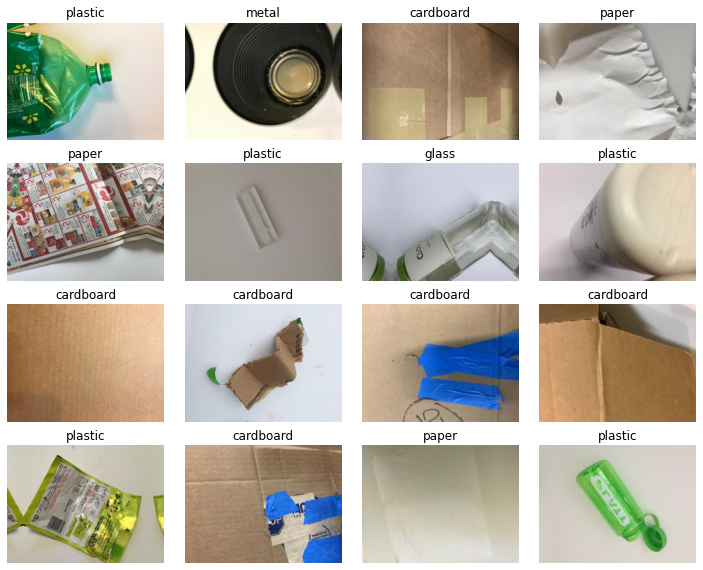

In [228]:
# 데이터 확인
data.show_batch(rows=4,figsize=(10,8))

In [168]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

print(train_dir)
print(test_dir)

/content/data/train
/content/data/test


In [169]:
train_cardboard_dir = os.path.join(train_dir, 'cardboard') 
train_glass_dir = os.path.join(train_dir, 'glass')
train_metal_dir = os.path.join(train_dir, 'metal')
train_paper_dir = os.path.join(train_dir, 'paper')
train_plastic_dir = os.path.join(train_dir, 'plastic')
train_trash_dir = os.path.join(train_dir, 'trash')


test_cardboard_dir = os.path.join(test_dir, 'cardboard') 
test_glass_dir = os.path.join(test_dir, 'glass')
test_metal_dir = os.path.join(test_dir, 'metal')
test_paper_dir = os.path.join(test_dir, 'paper')
test_plastic_dir = os.path.join(test_dir, 'plastic')
test_trash_dir = os.path.join(test_dir, 'trash')

In [170]:
# train과 test크기 확인
num_cardboard_tr = len(os.listdir(train_cardboard_dir))
num_glass_tr = len(os.listdir(train_glass_dir))
num_metal_tr = len(os.listdir(train_metal_dir))
num_paper_tr = len(os.listdir(train_paper_dir))
num_plastic_tr = len(os.listdir(train_plastic_dir))
num_trash_tr = len(os.listdir(train_trash_dir))


num_cardboard_test = len(os.listdir(test_cardboard_dir))
num_glass_test = len(os.listdir(test_glass_dir))
num_metal_test = len(os.listdir(test_metal_dir))
num_paper_test = len(os.listdir(test_paper_dir))
num_plastic_test = len(os.listdir(test_plastic_dir))
num_trash_test = len(os.listdir(test_trash_dir))


total_train = num_cardboard_tr + num_glass_tr + num_metal_tr + num_paper_tr + num_plastic_tr + num_trash_tr
total_test = num_cardboard_test + num_glass_test + num_metal_test + num_paper_test + num_plastic_test + num_trash_test

print("Total training images:", total_train)
print("Total test images:", total_test)

Total training images: 1892
Total test images: 635


In [207]:
batch_size = 32
epochs = 20
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [172]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [176]:
# 이미지 불리기
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [177]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1892 images belonging to 6 classes.


In [178]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 635 images belonging to 6 classes.


In [249]:
from tensorflow.keras.layers import Flatten

model = Sequential([
    Conv2D(16, 3, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.2),

    Conv2D(16, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(32, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same'),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dense(6)
])

model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch = int(total_train/batch_size),
    workers=4,
    validation_data=test_data_gen,
)

Epoch 1/20
59/59 [==============================] - 12s 197ms/step - loss: 1.7377 - accuracy: 0.2220 - val_loss: 1.7373 - val_accuracy: 0.2346
Epoch 2/20
59/59 [==============================] - 11s 187ms/step - loss: 1.7217 - accuracy: 0.2269 - val_loss: 1.6996 - val_accuracy: 0.2063
Epoch 3/20
59/59 [==============================] - 11s 185ms/step - loss: 1.6660 - accuracy: 0.3032 - val_loss: 1.6411 - val_accuracy: 0.2677
Epoch 4/20
59/59 [==============================] - 11s 185ms/step - loss: 1.5553 - accuracy: 0.3269 - val_loss: 1.6315 - val_accuracy: 0.2488
Epoch 5/20
59/59 [==============================] - 11s 185ms/step - loss: 1.5528 - accuracy: 0.3306 - val_loss: 1.5012 - val_accuracy: 0.3937
Epoch 6/20
59/59 [==============================] - 11s 186ms/step - loss: 1.5184 - accuracy: 0.3538 - val_loss: 1.4844 - val_accuracy: 0.4126
Epoch 7/20
59/59 [==============================] - 11s 186ms/step - loss: 1.4760 - accuracy: 0.3651 - val_loss: 1.5122 - val_accuracy: 0.3449

In [251]:
model.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_425 (Conv2D)          (None, 100, 100, 16)      448       
_________________________________________________________________
activation_327 (Activation)  (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_323 (MaxPoolin (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_281 (Dropout)        (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_426 (Conv2D)          (None, 50, 50, 16)        2320      
_________________________________________________________________
activation_328 (Activation)  (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_324 (MaxPoolin (None, 25, 25, 16)      

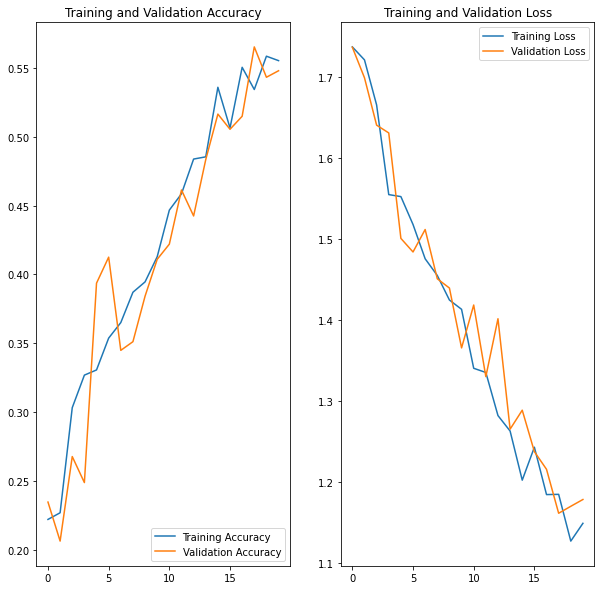

In [250]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [252]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/trained_model.h5 
